<a href="https://colab.research.google.com/github/sangeetamteli/K-Means/blob/main/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![DATE Header.jpg](attachment:d990dd25-b6b4-4c99-8e07-2151d4f26ad3.jpg)

## PRASHANTH KANNADAGULI

### Convolutional Neural Networks

## Learning Objectives

At the end of the experiment, you will be able to

* distinguish between Feed Forward (fully connected) neural networks and Convolutional neural networks
* understand terms like filtering, convolution, pooling
* build CNN model to tackle fashion mnist dataset
* perform 1D convolution on a time series dataset
* know various CNN architectures: AlexNet and ResNet
* build AlexNet architecture using Keras Sequential API

## Information

The idea of the CNN was derived from the biological process of how the visual cortex is structured and works.

As per the study of David H. and Torsten Wheel,

* neurons in the visual cortex have a local **receptive field** that means neurons will respond to stimuli only in the restricted region, and

* receptive fields of all neurons combine to make the whole visual image.

The above study inspired the paper Neocognitron in 1980 and which later evolved into Convolutional Neural networks (CNN).

The most important building block of a CNN is the convolutional layer.

### Convolutional Layers

Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers of DNN), but only to pixels in their receptive fields as shown in the figure below. In turn, each neuron in the second convolutional layer is connected only to neurons located within a receptive field in the first layer.

This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on.
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/conv_layers_multiple_fmap.png" width=600px/>
</center>
$\hspace{6cm} \text {Convolutional layers with multiple feature maps, and images with three color channels}$
<br><br>

A neuron’s weights can be represented as a small image with the size of the receptive field. This is termed as **filter**. And, a layer full of neurons using the same filter outputs a **feature map**, which highlights the areas in an image that activate the filter the most.

A convolutional layer has multiple filters and outputs one feature map per filter, also:

* it has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term).

* neurons in different feature maps use different parameters.

* a neuron’s receptive field extends across all the previous layers’ feature maps i.e, its shape will be $f_h$ x $f_w$ x depth of previous layer, where $f_h$ and $f_w$ are the height and width of the receptive field.

In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

For instance, if the input image and the filter look like the following:
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/CNN_Img1_.png" width=400px/>
</center>

The filter (green) slides over the input image (blue) one pixel at a time starting from the top left. The filter multiplies its own values with the overlapping values of the image while sliding over it and adds all of them up to output a single value for each overlap until the entire image is traversed:
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/CNN_Img2_.gif" width=500px/>
</center>

In the case of images with multiple channels (e.g. RGB), the Kernel has the same depth as that of the input image. Matrix Multiplication is performed between $K_n$ and $I_n$ stack ([$K_1,I_1$], [$K_2,I_2$], [$K_3,I_3$]) and all the results are summed with the bias to give us a squashed one-depth channel Convoluted Feature Output:

<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/CNN_Img3_.gif" width=900px/>
</center>

**Note that:**

* all neurons located in the same row $i$ and column $j$ but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

* we do not have to define the filters manually: instead, during training, the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.

In [1]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TRAIN.tsv")
    ipython.magic("sx wget https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TEST.tsv")
    return

setup()

### Import required packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, InputLayer, Conv1D, ReLU, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

#### Using a TensorFlow implementation, we will now understand convolutional operations on images

* Applying a convolutional filter
* Feature Map generation
* Stride and Padding



In TensorFlow,

* each input image is typically represented as a 3D tensor of shape
[height, width, channels].

* A mini-batch is represented as a 4D tensor of shape [minibatch size, height, width, channels].

* The weights of a convolutional layer are represented as a 4D tensor of shape [$f_h$, $f_w$, $f_{n′}$, $f_n$].

* The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [$f_n$].

where

$f_h$ is filter (or receptive field) height,

$f_w$ is filter width,

$f_{n′}$ is number of feature maps in the previous layer (layer $l – 1$), and

$f_n$ is number of feature maps in the current layer (layer $l$).

Let's creates two filters and apply them to Chinese temple and flower images.

In the following code we use Scikit-Learn’s `load_sample_image()` (which loads two color images, one of a Chinese temple, and the other of a flower).

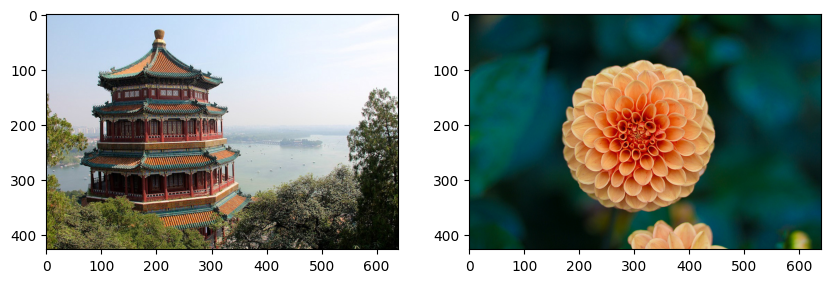

((427, 640, 3), (427, 640, 3))

In [3]:
# Load sample images
china = datasets.load_sample_image("china.jpg")
flower = datasets.load_sample_image("flower.jpg")

# Scale image features
china = china / 255
flower = flower / 255

# Visualize images
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(china)
ax[1].imshow(flower)
plt.show()
china.shape, flower.shape

In [4]:
# Combine images as single 4D array
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
batch_size, height, width, channels

(2, 427, 640, 3)

Create two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).

Note that shape should be [$f_h$, $f_w$, $f_{n′}$, $f_n$].

In [5]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
# vertical line
filters[:, 3, :, 0] = 1
# horizontal line
filters[3, :, :, 1] = 1
filters.shape

(7, 7, 3, 2)

Apply the filters to both images using the `tf.nn.conv2d()` function, which is part of TensorFlow’s low-level Deep Learning API.

Here, we use zero padding (`padding="SAME"`) and a stride of 1.

In [11]:
# Convolutional layer
outputs = tf.nn.conv2d(images, filters, strides=1,padding="SAME")

1st feature map through verticle filter


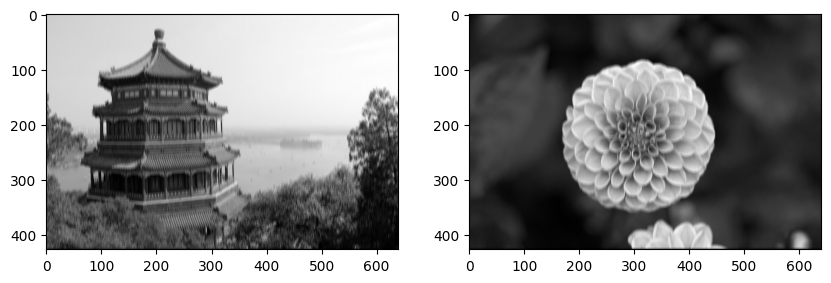

In [12]:
# Images' 1st feature map using vertical filter
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(outputs[0, :, :, 0], cmap="gray")
ax[1].imshow(outputs[1, :, :, 0], cmap="gray")
print("1st feature map through verticle filter")
plt.show()

2nd feature map through horizontal filter


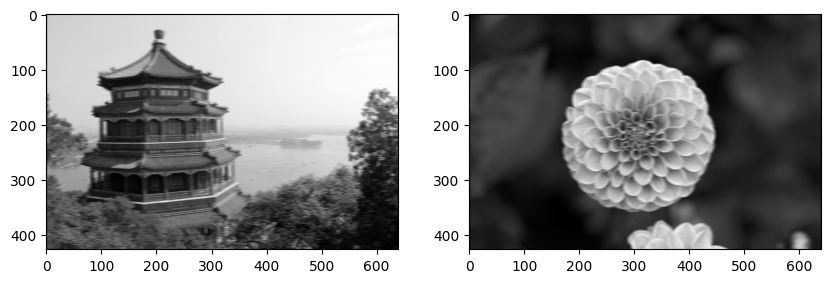

In [13]:
# Images' 2nd feature map using horizontal filter
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(outputs[0, :, :, 1], cmap="gray")
ax[1].imshow(outputs[1, :, :, 1], cmap="gray")
print("2nd feature map through horizontal filter")
plt.show()

In `tf.nn.conv2d()`:

* **images** is the input mini-batch (a 4D tensor).

* **filters** is the set of filters to apply (also a 4D tensor).

* **strides** is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).

* **padding** must be either "SAME" or "VALID":

  * If set to "SAME", the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up. For example, if the input size is 13 and the stride is 5 as shown in the figure below, then the output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are added as evenly as possible around the inputs, as needed.

  * If set to "VALID", the convolutional layer does not use zero padding and may
ignore some rows and columns at the bottom and right of the input image,
depending on the stride. This means that every neuron’s receptive field lies strictly within valid positions inside the input, hence the name valid.
<br><br>
<center>
<img src="https://wizardforcel.gitbooks.io/scikit-and-tensorflow-workbooks-bjpcjp/content/pics/padding-options.png" width=450px/>
</center>
$\hspace{9.5cm} \text {Different padding options}$

In the above example, we manually defined the filters, but in a real CNN we would normally define filters as trainable variables so the neural net can learn which filters work best. Instead of manually creating the variables, use the `keras.layers.Conv2D` layer:

In [16]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

As we can see, convolutional layers have quite a few hyperparameters and we can use cross-validation to find the right values, but this is very time-consuming.

Also, CNNs' convolutional layers require a huge amount of RAM. This problem is taken care of by the second common building block of CNNs: the pooling layer.

### Pooling Layers

The goal of the pooling layer is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters. Each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a receptive field.

However, **a pooling neuron has no weights**; all it does is aggregate the inputs using an aggregation function such as the **max** or **mean**.

The below figure shows a max pooling layer, with a 2 × 2 pooling kernel, stride of 2 and no padding. Only the max input value in each receptive field makes it to the next layer. Because of the stride of 2, the output image has half the size of the input image.
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Pooling_layer.png" width=600px/>
</center>
$\hspace{7cm} \text {Max pooling layer (2x2 pooling kernel, stride 2(max 3 ,4), no padding)}$
<br><br>


#### Using a TensorFlow implementation, we will now understand pooling operation on images

* Applying a pooling layer
* Image compression

The following code creates a max pooling layer using a 2 × 2 kernel and applies it to `images`. The strides default to the kernel size, so this layer will use a stride of 2 (both horizontally and vertically):

In [17]:
# Pooling layer
max_pool = keras.layers.MaxPool2D(pool_size=2, padding="valid", dtype='float64')(images)

To create an average pooling layer, just use AvgPool2D instead of MaxPool2D.

Images before and after pooling operation:


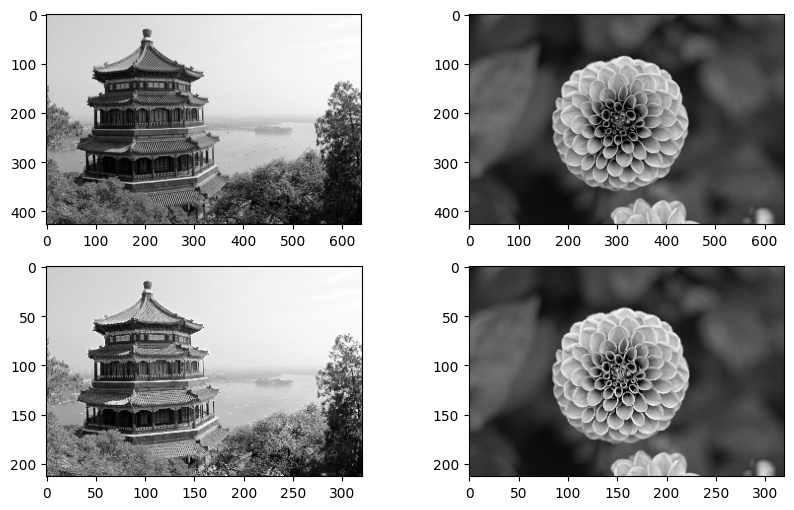

In [18]:
# Images before and after pooling operation, showing only single channel
fig, ax = plt.subplots(2,2, figsize=(10,6))

ax[0][0].imshow(images[0, :, :, 1], cmap="gray")
ax[0][1].imshow(images[1, :, :, 1], cmap="gray")

ax[1][0].imshow(max_pool[0, :, :, 1], cmap="gray")
ax[1][1].imshow(max_pool[1, :, :, 1], cmap="gray")

print("Images before and after pooling operation:")
plt.show()

In [19]:
# Compression ratio
original_bytes = images.nbytes
pooling_bytes = np.array(max_pool).nbytes
ratio = pooling_bytes / original_bytes
print("The compression ratio between the original images size and the total size after pooling is:", ratio)

The compression ratio between the original images size and the total size after pooling is: 0.24941451990632318


From the above results, we can see that the images are shrunk.

Now we know all the building blocks to create convolutional neural networks.
Let's perform a 1D convolution on a time series dataset.

### 1D Convolution

**Dataset description**

The dataset we are using here is a time series data and is called FordA. It contains 3601 training instances and another 1320 testing instances. Each time series corresponds to a measurement of engine noise captured by a motor sensor. For this task, the goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task.

To know more about this dataset, click [here](http://www.j-wichard.de/publications/FordPaper.pdf).

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing.

In [20]:
import pandas as pd
df_train = pd.read_csv("FordA_TRAIN.tsv", delimiter="\t", header=None)
df_test = pd.read_csv("FordA_TEST.tsv", delimiter="\t", header=None)

In [21]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


The first column corresponds to the label (-1 or 1).

In [22]:
# Train and test data
x_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].astype(int)
x_test =  df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].astype(int)
x_train.shape, x_test.shape

((3601, 500), (1320, 500))

Visualize one time series example for each class in the dataset.

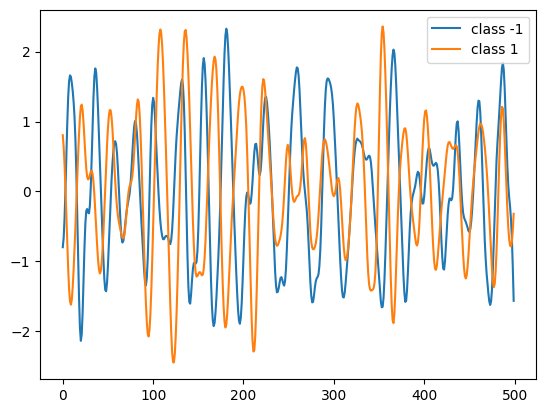

In [23]:
# Visualize one time series per class
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()

Note that the time series data used here are univariate, meaning we only have one channel per time series example. Therefore, we need to transform it into a multivariate one with one channel. This will allow us to construct a model that is easily applicable to multivariate time series.

In [24]:
# Reshape training set
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train.shape, x_test.shape

((3601, 500, 1), (1320, 500, 1))

In [25]:
# Shuffle the training set
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers. The expected labels will then be 0 and 1.

In [26]:
# Change label -1 to 0
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [27]:
# Create model
# BatchNormalization() -> normalization between layers of cnn. because cnn generates larger values
model = Sequential([
                    InputLayer(x_train.shape[1:]),
                    Conv1D(filters=64, kernel_size=3, padding="same"),
                    BatchNormalization(),
                    ReLU(),
                    Conv1D(filters=64, kernel_size=3, padding="same"),
                    BatchNormalization(),
                    ReLU(),
                    Conv1D(filters=64, kernel_size=3, padding="same"),
                    BatchNormalization(),
                    ReLU(),
                    GlobalAveragePooling1D(),
                    Dense(2, activation="softmax")
                    ])

In [28]:
# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 500, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,858 (101.01 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
# Train the model
callbacks = [ keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")]

history = model.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks=callbacks, validation_split=0.2)

Epoch 1/10
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.6241

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.6294 - val_loss: 0.8166 - val_sparse_categorical_accuracy: 0.5062
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4866 - sparse_categorical_accuracy: 0.7683 - val_loss: 0.8748 - val_sparse_categorical_accuracy: 0.5062
Epoch 3/10
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4821 - sparse_categorical_accuracy: 0.7490

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4800 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.5062
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4347 - sparse_categorical_accuracy: 0.7776

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4346 - sparse_categorical_accuracy: 0.7776 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.5146
Epoch 5/10
85/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4265 - sparse_categorical_accuracy: 0.7976

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4261 - sparse_categorical_accuracy: 0.7975 - val_loss: 0.5102 - val_sparse_categorical_accuracy: 0.7420
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4153 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.5538 - val_sparse_categorical_accuracy: 0.6422
Epoch 7/10
76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4016 - sparse_categorical_accuracy: 0.7937

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4011 - sparse_categorical_accuracy: 0.7950 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.7295
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4038 - sparse_categorical_accuracy: 0.8053 - val_loss: 0.4843 - val_sparse_categorical_accuracy: 0.7184
Epoch 9/10
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.8004

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.3665 - val_sparse_categorical_accuracy: 0.8280
Epoch 10/10
80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3863 - sparse_categorical_accuracy: 0.8244

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.3619 - val_sparse_categorical_accuracy: 0.8350


In [30]:
# Evaluate model on test set
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss", test_loss)
print("Test accuracy", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3470 - sparse_categorical_accuracy: 0.8479
Test loss 0.3600883185863495
Test accuracy 0.842424213886261


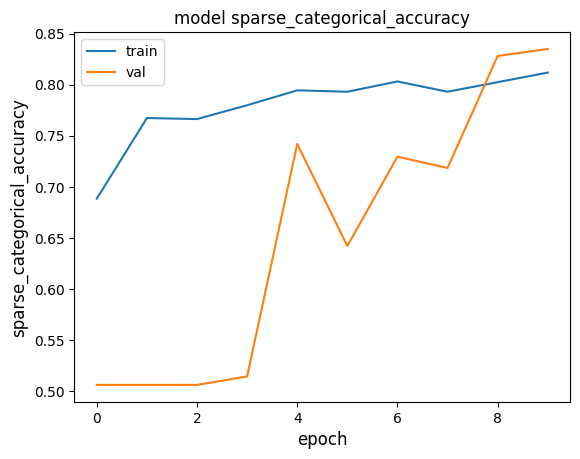

In [31]:
# Visualize model's training and validation metrics
metric = "sparse_categorical_accuracy"

plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])

plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

From the above plot, we can see that the network still needs training.

Now, let's see how a 2D convolution works. First, we understand a typical CNN architecture.

### CNN Architecture

Typical CNN architectures stack a few convolutional layers (generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. The image gets smaller and smaller as it progresses through the network, but it also gets deeper and deeper (i.e., with more feature maps), as shown in the figure below. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction.

<br><br>
<center>
<img src="https://i1.wp.com/thecleverprogrammer.com/wp-content/uploads/2020/11/1-cnnlayer.png?resize=1024%2C259&ssl=1" width=600px/>
</center>

$\hspace{11cm} \text {CNN architecture}$
<br><br>

Here is how we can implement a simple CNN to tackle the Fashion MNIST dataset:

In [32]:
# Using Keras to load the dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Label:  9


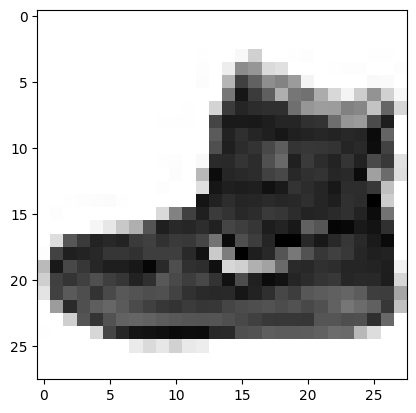

In [33]:
# Visualize an image from data
print("Label: ", y_train_full[0])
plt.imshow(X_train_full[0], cmap='Greys')
plt.show()

In [34]:
# Shape and datatype of X_train
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [35]:
# Split into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=123)
X_train.shape, X_val.shape

((48000, 28, 28), (12000, 28, 28))

In [36]:
# Reshape train, test, and validation data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_train.shape, X_val.shape, X_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/CNN_architecture_fmnist.png" width=900px/>
</center>
$\hspace{7.5cm} \text {CNN architecture used for Fashion MNIST dataset}$
<br><br>

The CNN architecture used for FMNIST dataset is shown in the figure above and its corresponding sequential model is created using the code below:

In [37]:
# Create model
model = Sequential([
                    Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
                    MaxPooling2D(2),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    Conv2D(128, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    Conv2D(256, 3, activation="relu", padding="same"),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dropout(0.5),
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(10, activation="softmax")
                    ])

Let’s go through this model:

* The first layer uses 64 fairly large filters (7 × 7) but no stride because the input images are not very large. It also sets input_shape=[28, 28, 1], because the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).

* Next, we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

* Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter we can tune).

* Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features.

* Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs since a dense network expects a 1D array of features for each instance. We also add two dropout layers, to reduce overfitting.

In [38]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

Here we use `ImageDataGenerator` that generates batches of tensor image data with real-time data augmentation. The images output by the generator will have the same dimensions as the input images. It lets us augment the images in real-time while the model is still training.

We can apply any random transformations on the training image as it is passed to the model. Few parameters are:

* **rescale**: scale the image
* **horizontal_flip**: randomly flip inputs horizontally
* **width_shift_range**: shift the image to the left or right (horizontal shifts)
* **height_shift_range**: shift the image vertically (up or down)
* **rotation_range**: degree range for random rotations of the image

To know more about ImageDataGenerator, click [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [39]:
# Model Parameters
batch_size = 256

# Instantiate ImageDataGenerator
gen = ImageDataGenerator(rescale = 1.0/255,
                         width_shift_range = 0.005,
                         height_shift_range = 0.005,
                         rotation_range = 0,
                         horizontal_flip = True)

# Generate batches of tensor image data
train_batches = gen.flow(X_train, y_train, batch_size = batch_size)
val_batches = gen.flow(X_val, y_val, batch_size = batch_size)

**Note:** Use [`flow_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) to load images from the directory. It takes the path to a directory & generates batches of augmented data.

In [40]:
# Train the model
history = model.fit(train_batches,
                    steps_per_epoch = X_train.shape[0]//batch_size,
                    epochs = 1,
                    validation_data = val_batches,
                    validation_steps = X_val.shape[0]//batch_size)

187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 116ms/step - accuracy: 0.4403 - loss: 1.5131 - val_accuracy: 0.8285 - val_loss: 0.4947


In [41]:
# Instantiate ImageDataGenerator
test_gen = ImageDataGenerator(rescale=1.0/255)
# Generate batches of tensor image data
test_batches = test_gen.flow(X_test, y_test, batch_size= 50)

# Evaluate Model against test data and get the score
score = model.evaluate(test_batches)

# Print Metrics
print('Test loss:', score[0])
print('Test accuracy:', score[1])

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8156 - loss: 0.5159
Test loss: 0.51881343126297
Test accuracy: 0.8137999773025513


By increasing the number of epochs, the accuracy can be improved.

In [42]:
# Predict class probabilities for first three instances of X_test
X_new = X_test[-3:]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [43]:
# List of labels
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [44]:
# Predict class labels for first three instances of X_test
y_pred = np.argmax(model.predict(X_new), axis=-1)
print("Predicted labels: \n", y_pred)

print(np.array(class_names)[y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted labels: 
 [8 1 7]
['Bag' 'Trouser' 'Sneaker']


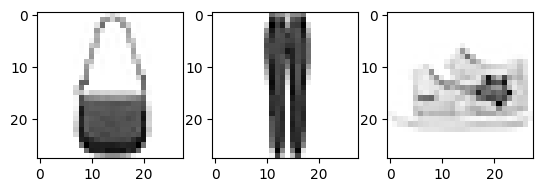

In [45]:
# Actual labels
fig, ax = plt.subplots(1,3)
for axi, i in zip(ax.ravel(), np.arange(len(X_new))):
    axi.imshow(X_new[i].reshape(28, 28), cmap='Greys')

From the above results, we can see the performance of network on three images.

Now, let's look at the AlexNet architecture.

### AlexNet

The AlexNet CNN architecture won the 2012 ImageNet ILSVRC challenge by a
large margin. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer. The table given below presents this architecture.
<br><br>

|  Layer  |  Type  | Maps  |  Size  |  Kernel Size | Stride  |  Padding  |  Activation  
|:--------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|  Out  | Fully connected | - |  1,000 | - | - | - | Softmax |
| F10 | Fully connected | - | 4,096 | - | - | - | ReLU |
| F9 | Fully connected | - | 4,096 | - | - | - | ReLU |
| S8 | Max pooling | 256 | 6 x 6 | 3 x 3 | 2 | valid | - |
| C7 | Convolution | 256 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| C6 | Convolution | 384 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| C5 | Convolution | 384 | 13 x 13 | 3 x 3 | 1 | same | ReLU |
| S4 | Max pooling | 256 | 13 x 13 | 3 x 3 | 2 | valid | - |
| C3 | Convolution | 256 | 27 x 27 | 5 x 5 | 1 | same | ReLU |
| S2 | Max pooling | 96 | 27 x 27 | 3 x 3 | 2 | valid | - |
| C1 | Convolution | 96 | 55 x 55 | 11 x 11 | 4 | valid | ReLU |
| In | Input | 3 (RGB) | 227 x 227 | - | - | - | - |

$\hspace{11cm} \text {AlexNet architecture}$
<br><br>

To reduce overfitting, the authors used two regularization techniques:

* **dropout** with a 50% dropout rate during training to the outputs of layers F9 and F10

* **data augmentation** by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

Let's build the AlexNet architecture and train it on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The dataset contains 60,000 colour images, each with dimensions 32x32px. The content of the images within the dataset is sampled from 10 classes.


In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# List to refer labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

By default, the CIFAR dataset is partitioned into 50,000 training data and 10,000 test data.

In [ ]:
# Shape of train and test images
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

Instead of taking all the 50000 instances for training, we will only use the first 5000 instances as validation set and next the 5000 instances as training set.

In [ ]:
# Validation data
val_images, val_labels = train_images[:5000], train_labels[:5000]
# Training data
train_images, train_labels = train_images[5000:10000], train_labels[5000:10000]

To ease data manipulation and modification we transform the dataset into a TensorFlow dataset using `tf.data.Dataset.from_tensor_slices` method.

In [ ]:
# Convert to TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

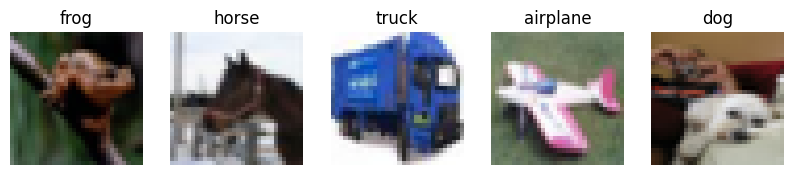

In [ ]:
# Visualize few images
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

Now as per the network, we need to do few preprocessing steps:

* Normalize images to have a mean of 0 and standard deviation of 1

* Resizing of the images from 32 x 32 to 227 x 227. The AlexNet network input expects a 227x227 image.

We create a function called `process_images` for this purpose.

In [ ]:
def process_images(image, label):
    ''' Normalize images to have a mean of 0 and standard deviation of 1,
        resize images from 32x32 to 227x227 '''
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
# Size of training, testing, validation set
train_ds_size = len(train_ds)
test_ds_size = len(test_ds)
val_ds_size = len(val_ds)
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", val_ds_size)

Training data size: 5000
Test data size: 10000
Validation data size: 5000


In [ ]:
# Perform preprocessing with shuffle and batch data operations
train_ds = (train_ds.map(process_images)
                    .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=32, drop_remainder=True))

test_ds = (test_ds.map(process_images)
                  .shuffle(buffer_size=test_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

val_ds = (val_ds.map(process_images)
                .shuffle(buffer_size=val_ds_size)
                .batch(batch_size=32, drop_remainder=True))

Model implementation

In [ ]:
# Create AlexNet CNN architecture
model = Sequential([
                    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
                    BatchNormalization(),
                    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
                    BatchNormalization(),
                    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                    Flatten(),
                    Dense(4096, activation='relu'),
                    Dropout(0.5),
                    Dense(4096, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation='softmax')
                    ])

In [ ]:
# Compile model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.optimizers.SGD(learning_rate = 0.001), metrics = ['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,327,818 (222.50 MB)

 Trainable params: 58,325,066 (222.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
# Train model on training set
history = model.fit(train_ds, epochs = 1, validation_data = val_ds)

156/156 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - accuracy: 0.1588 - loss: 3.6826 - val_accuracy: 0.3029 - val_loss: 1.9879


In [ ]:
# Model performance on test set
model.evaluate(test_ds)

312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.2970 - loss: 1.9952


[1.9938589334487915, 0.2996794879436493]

By increasing the number of training instances and epochs, the model performance can be increased.

Other than AlexNet we have few more CNN architectures such as ResNet.

### ResNet (Residual Network) **(Optional)**

Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (or
ResNet). The winning variant used an extremely deep CNN composed of 152 layers (other variants had 34, 50, and 101 layers).

It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use **skip connections** (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack.

When training a neural network, the goal is to make it model a target function $h(x)$. If we add the input $x$ to the output of the network (i.e., we add a skip connection), then the network will be forced to model $f(x) = h(x) – x$ rather than $h(x)$. This is called **residual learning** as shown below.
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Residual_learning.png" width=450px/>
</center>

$\hspace{10cm} \text {Residual learning}$
<br><br>

When we initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If we add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function, this will speed up training considerably.

ResNet’s architecture can be seen in the figure below. It has in between very deep stack of simple residual units. Each residual unit is composed of two convolutional layers, with Batch Normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding).
<br><br>
<center>
<img src="https://miro.medium.com/max/1294/0*65jDuZ6VTgaLUSuk.png" width=600px/>
</center>

$\hspace{10cm} \text {ResNet architecture}$
<br><br>

**Note that** the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don’t have the same shape (for example, this problem affects the skip connection represented by the dashed arrow in the figure given above ResNet architecture).

To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps (as shown below).
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Skip_connection.png" width=500px/>
</center>

$\hspace{8cm} \text {Skip connection when changing feature map size and depth}$
<br><br>

### Implementing a ResNet-50 CNN Using Pretrained Models from Keras

We can load the ResNet-50 model, pretrained on ImageNet, from keras.applications package, with the following line of code:

In [46]:
# Load pretrained ResNet50 model
model = keras.applications.resnet50.ResNet50(weights="imagenet");

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. To use it, we first need to ensure that the images have the right size. A ResNet-50 model expects 224 × 224-pixel images.

Images before reshape


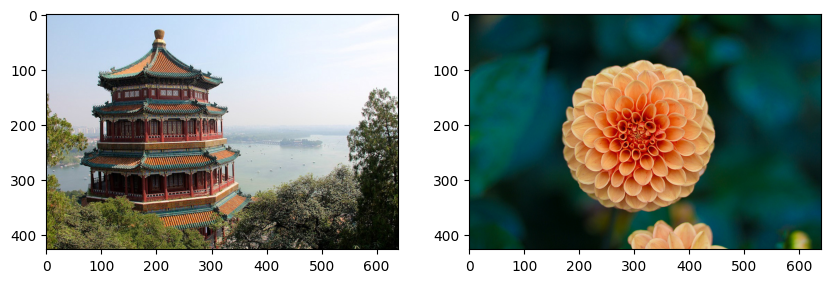

In [47]:
# Images before reshape
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(images[0])
ax[1].imshow(images[1])
print("Images before reshape")
plt.show()

In [ ]:
# Crop range(positions) in percentages
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

# Reshape images
images_resized = tf.image.crop_and_resize( images, boxes=[china_box, flower_box], box_indices=[0,1], crop_size=[224,224])

Images after reshape


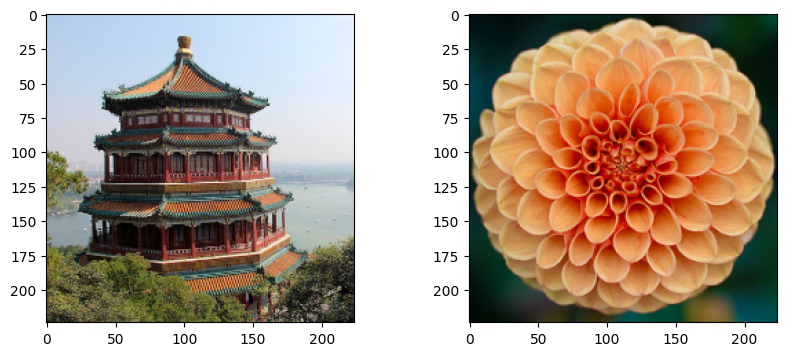

In [ ]:
# Images after reshape
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(images_resized[0])
ax[1].imshow(images_resized[1])
print("Images after reshape")
plt.show()

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on. Each model provides a `preprocess_input()` function. These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [ ]:
# Preprocess images
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

Use the pretrained model to make predictions:

In [ ]:
# Make prediction
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


As usual, the output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). To display the top K predictions, including the class name and the estimated probability of each predicted class, use the `decode_predictions()` function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier, its name, and the corresponding confidence score:

In [ ]:
# Top k predictions
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
      print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.08%
 n03781244 - monastery    11.69%

Image #1
 n04522168 - vase         53.97%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.96%



The correct classes (monastery and daisy) appear in the top three results for both images. That’s pretty good, considering that the model had to choose from among 1,000 classes.

### Reference:

1. https://medium.com/swlh/setting-up-google-colab-for-cnn-modeling-55b5208599c4

### Theory Questions

1. What are the advantages of a CNN over a fully connected DNN for image classification?

 These are the main advantages of a CNN over a fully connected DNN for image
classification:

  * Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
  
  * When a CNN has learned a kernel that can detect a particular feature, it can
detect that feature anywhere in the image. In contrast, when a DNN learns a
feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.

  * Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN’s architecture embeds this prior
knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.

2. Why would you want to add a max pooling layer rather than a convolutional
layer with the same stride?

 A max pooling layer has no parameters at all, whereas a convolutional layer has
quite a few.